In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os

**Step 1: Load data**

In [2]:
cd = os.getcwd()
file = os.path.join(cd[: -7], 'Data', 'cookie_cats.csv')
df = pd.read_csv(file)
display(df)
df.dtypes

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

**Step 2: Problem Understanding**
> Does moving the first gate from Level 30 to Level 40 improve player retention?

> Define metrics:\
Retention 1-day Rate = Players who returned Day 1 / Total players in group.
Retention 7-day Rate = Players who returned Day 7 / Total players in group.

> Define hypothesis:\
Null hypothesis: Moving the gate from Level 30 to Level 40 does not make an impact.\
\
Alternative hypothesis: Moving the gate to Level 40 does make an impact (two-tailed).

**Step 3: Preprocessing and Exploratory Data Analysis**

1. Check for missing values, duplicates, etc.
2. Summary Statistics.
3. Plot Distributions.

1. Check for missing values.
> There are zero missing values or duplicate rows. This is great! I don't need fix data quality issues.

In [3]:
df.info()

duplicates= df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
Number of duplicate rows: 0


2. Summary Statistics.
> We can see there is a fairly even split between users who saw the gate at Level 30 vs. Level 40. This is great!\
Additionally, the distribution of sum_gamerounds seems normal except for the max of 49,854 game rounds - which might be an outlier.

In [4]:
display(df.groupby('version').count())
df['sum_gamerounds'].describe()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

>I want to see the difference in Retention_1 and Retention_7 by Level 30 and 40 gates. It looks like in general, the users who were gated in level 40 have lower retention in both 1 day and 7 days after installing the game.

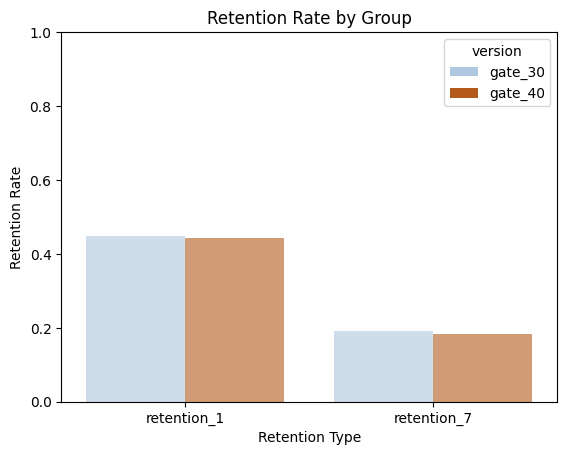

In [5]:
retention_rates = df.groupby('version')[['retention_1', 'retention_7']].mean().reset_index()
retention_rates_melted = retention_rates.melt(id_vars='version', var_name='Retention Type', value_name='Rate')

custom_palette = ["#A7C7E7", "#CC5500"]  # Pale blue, Burnt orange

ax = sns.barplot(x='Retention Type', y='Rate', hue='version', data=retention_rates_melted, palette=custom_palette)

for bar in ax.patches:
    bar.set_alpha(0.6)

plt.ylabel('Retention Rate')
plt.title('Retention Rate by Group')
plt.ylim(0, 1)
plt.show()

**Step 4: Hypothesis Testing**
>The goal is to compare retention rates between both groups on retention_1 and retention_7.\
To create a distribution of the retention rate, I will use bootstrapping to repeatedly re-sample the dataset and calculate the retention rate.

Retention_1: Retention after 1 day slightly decreases when the gate is increased to level 40. Let's review this variable to establish confidence.

In [6]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

In [7]:
def bootstrap_retention(df, column = 'retention_1', n_iterations = 1000): # function to calculate retention rate over 
    chi2_stats = []
    boot_means = []
    for i in range(n_iterations):
        boot_sample = df.sample(frac = 1, replace = True)
        boot_mean = boot_sample.groupby('version')[column].mean()
        boot_means.append(boot_mean)
    return pd.DataFrame(boot_means)

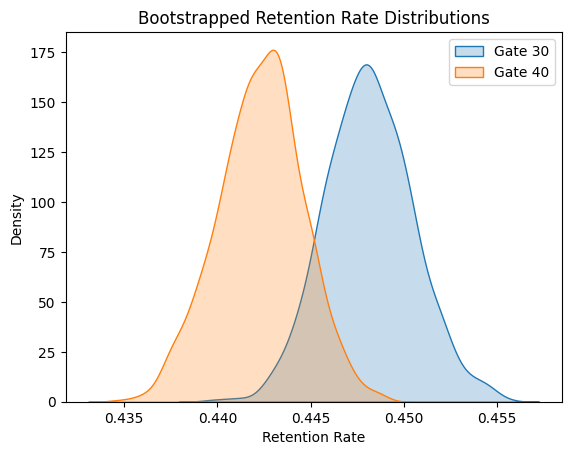

In [8]:
# Compare 1 day retention 

retention_1_df = bootstrap_retention(df, column = "retention_1", n_iterations = 1000)

sns.kdeplot(retention_1_df["gate_30"], label="Gate 30", fill=True)
sns.kdeplot(retention_1_df["gate_40"], label="Gate 40", fill=True)
plt.xlabel("Retention Rate")
plt.ylabel("Density")
plt.legend()
plt.title("Bootstrapped Retention Rate Distributions")
plt.show()

Calculate Bootstrap Confidence Intervals:
> We reject the Null hypothesis since the retention difference != 0 in either the lower or upper 2.5%.

In [9]:
retention_1_df['diff'] = retention_1_df['gate_40'] - retention_1_df['gate_30']

conf_int = np.percentile(retention_1_df['diff'], [2.5, 97.5])

print(f"95% Confidence Interval: {conf_int}")

95% Confidence Interval: [-0.01263427  0.00061182]


Permutation Test:
> We also reject the Null hypothesis as our estimated p-value is not significant (~0.97).

In [ ]:
obs_diff = df.groupby('version')['retention_1'].mean().diff().iloc[-1]

perm_diffs = []
for _ in range(1000):
    shuffled = df.copy()
    shuffled['version'] = np.random.permutation(df['version'])  # Shuffle labels
    perm_diff = shuffled.groupby('version')['retention_1'].mean().diff().iloc[-1]
    perm_diffs.append(perm_diff)

p_value = np.mean(np.array(perm_diffs) >= obs_diff)
print(f"P-value: {p_value}")

P-value: 0.97


Retention_7: Retention after 7 days slightly decreases when the gate is increased to level 40. Let's review this variable to establish confidence.

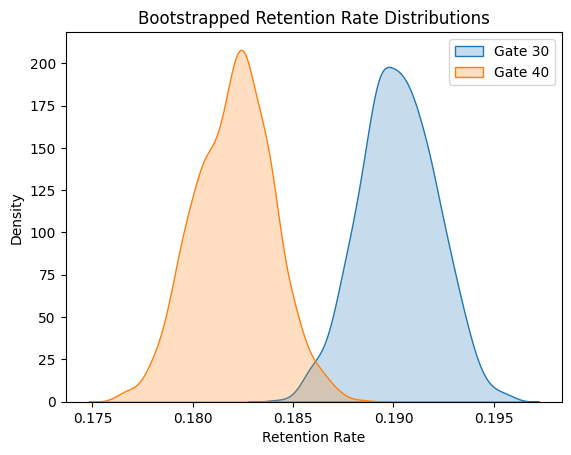

In [16]:
# Compare 7 day retention 

retention_7_df = bootstrap_retention(df, column = "retention_7", n_iterations = 1000)

sns.kdeplot(retention_7_df["gate_30"], label="Gate 30", fill=True)
sns.kdeplot(retention_7_df["gate_40"], label="Gate 40", fill=True)
plt.xlabel("Retention Rate")
plt.ylabel("Density")
plt.legend()
plt.title("Bootstrapped Retention Rate Distributions")
plt.show()

Calculate Bootstrap Confidence Intervals:
> We reject the Null hypothesis since the retention difference != 0 in either the lower or upper 2.5%.

In [17]:
retention_7_df['diff'] = retention_7_df['gate_40'] - retention_7_df['gate_30']

conf_int = np.percentile(retention_7_df['diff'], [2.5, 97.5])

print(f"95% Confidence Interval: {conf_int}")

95% Confidence Interval: [-0.01329887 -0.00317099]


Permutation Test:
> We also reject the Null hypothesis as our estimated p-value is not significant (~1.0).

In [19]:
obs_diff = df.groupby('version')['retention_7'].mean().diff().iloc[-1]

perm_diffs = []
for _ in range(1000):
    shuffled = df.copy()
    shuffled['version'] = np.random.permutation(df['version'])  # Shuffle labels
    perm_diff = shuffled.groupby('version')['retention_7'].mean().diff().iloc[-1]
    perm_diffs.append(perm_diff)

p_value = np.mean(np.array(perm_diffs) >= obs_diff)
print(f"P-value: {p_value}")

P-value: 1.0


**Step 5: Conclusion**
> We can see that changing the Gate from Level 30 to Level 40 does have a statistical impact on player retention 1 day and 7 days after signup.\
Add comparison so business can understand the impact. Gate 40 reduces retention in both cases.